## 1  Load Data

In [1]:
import pandas as pd
from datetime import datetime
# Paths to your files
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

# First attempt with folder ID
path1_10_present = 'foia-504-fy2010-present-asof-240930.csv'
path1_91_09 = 'foia-504-fy1991-fy2009-asof-240930.csv'

# Second attempt with folder name
path2_10_present = '/content/drive/My Drive/MS&E246/10_present.csv'
path2_91_09 = '/content/drive/My Drive/MS&E246/91_09.csv'

# Try reading with both paths
try:
    # Try first path
    df_10_present = pd.read_csv(path1_10_present)
    df_91_09 = pd.read_csv(path1_91_09)
    print("Successfully read from folder ID path")
except:
    try:
        # Try second path
        df_10_present = pd.read_csv(path2_10_present)
        df_91_09 = pd.read_csv(path2_91_09)
        print("Successfully read from folder name path")
    except Exception as e:
        print(f"Error: {e}")

C:\Users\caixu\AppData\Local\Temp\ipykernel_13920\1592800229.py:18: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_10_present = pd.read_csv(path1_10_present)


Successfully read from folder ID path


C:\Users\caixu\AppData\Local\Temp\ipykernel_13920\1592800229.py:19: DtypeWarning: Columns (12,13,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_91_09 = pd.read_csv(path1_91_09)


In [2]:
#What is the id of the dataset
id_columns = ['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip']

# Check for 10_present dataset
duplicates_10 = df_10_present.groupby(id_columns).size().reset_index(name='count')
has_duplicates_10 = any(duplicates_10['count'] > 1)

# Check for 91_09 dataset
duplicates_91 = df_91_09.groupby(id_columns).size().reset_index(name='count')
has_duplicates_91 = any(duplicates_91['count'] > 1)

print("Duplicates in 10_present:", has_duplicates_10)
print("Duplicates in 91_09:", has_duplicates_91)

# If there are duplicates, let's see some examples
if has_duplicates_10:
    print("\nExample duplicates in 10_present:")
    print(duplicates_10[duplicates_10['count'] > 1].head())

if has_duplicates_91:
    print("\nExample duplicates in 91_09:")
    print(duplicates_91[duplicates_91['count'] > 1].head())

Duplicates in 10_present: True
Duplicates in 91_09: True

Example duplicates in 10_present:
      AsOfDate  Program                   BorrName                BorrStreet  \
80   9/30/2024      504       1013 Enterprises LLC      1013 Lincoln Highway   
150  9/30/2024      504  10820 Hemlock Avenue, LLC      10820 Hemlock Avenue   
195  9/30/2024      504    1128 Petro Parkway, LLC    1128 Petroleum Parkway   
308  9/30/2024      504           123 Western, LLC  123 North Western Avenue   
528  9/30/2024      504                  1508, LLC  1508 Kaliste Saloom Road   

         BorrCity BorrState  BorrZip  count  
80   Schererville        IN    46375      2  
150       Fontana        CA    92337      2  
195     Broussard        LA    70518      2  
308       Chicago        IL    60612      2  
528     Lafayette        LA    70508      2  

Example duplicates in 91_09:
      AsOfDate  Program                        BorrName  \
236  9/30/2024      504               220PROPERTIES LLC   
248

## 2  Preliminary Cleaning

In [3]:
df_all = pd.concat([df_91_09, df_10_present])

In [4]:
def preliminary_clean_loan_data(df):
    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    print("Initial size:", len(df_clean))

    # 1. Clean Loan Status
    if 'Status' in df_clean.columns:
        status_col = 'Status'
    elif 'LoanStatus' in df_clean.columns:
        status_col = 'LoanStatus'

    # Print unique statuses before cleaning
    print("\nUnique loan statuses before cleaning:")
    print(df_clean[status_col].value_counts())

    # Remove canceled and not funded loans but keep CHGOFF with zero charge-off
    canceled_mask = df_clean[status_col].str.contains('CANCLD|CANCEL|Canceled|NOT FUNDED', na=False, case=False)
    df_clean = df_clean[~canceled_mask]

    # 2. Check monetary values
    monetary_cols = ['GrossApproval', 'ThirdPartyDollars', 'GrossChargeOffAmount']
    for col in monetary_cols:
        if col in df_clean.columns:
            # Remove negative values
            df_clean = df_clean[df_clean[col].fillna(0) >= 0]

    # 3. Check dates
    date_cols = ['AsOfDate', 'ApprovalDate', 'PaidInFullDate']

    for col in date_cols:
        if col in df_clean.columns:
            # Convert to datetime
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

            # Remove future dates (except AsOfDate which might be a reporting date)
            if col != 'AsOfDate':
                df_clean = df_clean[
                    (df_clean[col].isna()) |
                    (df_clean[col] <= pd.Timestamp.now())
                ]

    # 4. Check logical consistency
    # PaidInFullDate should be after ApprovalDate
    if 'PaidInFullDate' in df_clean.columns and 'ApprovalDate' in df_clean.columns:
        df_clean = df_clean[
            ~((df_clean['PaidInFullDate'].notna()) &
              (df_clean['PaidInFullDate'] < df_clean['ApprovalDate']))
        ]

    # 5. Remove rows with missing crucial information
    crucial_cols = ['BorrName', 'GrossApproval', status_col]
    df_clean = df_clean.dropna(subset=crucial_cols)

    print("\nFinal size after cleaning:", len(df_clean))
    print("\nUnique loan statuses after cleaning:")
    print(df_clean[status_col].value_counts())

    return df_clean

# Clean both datasets
df_clean = preliminary_clean_loan_data(df_all)

Initial size: 218095

Unique loan statuses before cleaning:
LoanStatus
PIF           107245
EXEMPT         59555
CANCLD         30641
CHGOFF         12078
NOT FUNDED      8226
Name: count, dtype: int64

Final size after cleaning: 178877

Unique loan statuses after cleaning:
LoanStatus
PIF       107244
EXEMPT     59555
CHGOFF     12078
Name: count, dtype: int64


## 3  Train/Test Split

In [5]:
CUTOFF = "2011-01-01"

### 3.1 Process loans with approval date before CUTOFF as training set:

In [6]:
## 3.1.1 Loans that have approval date before CUTOFF and are in EXEMPT state

df_before_and_exempt = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "EXEMPT")]
# Not default
df_before_and_exempt["Default"] = False
# Survival time is (CUTOFF - approval date)
df_before_and_exempt["SurvivalDays"] = (datetime.strptime(CUTOFF, '%Y-%m-%d') - df_before_and_exempt["ApprovalDate"]).dt.days
# Loss at default is 0
df_before_and_exempt["LossAtDefault"] = 0

In [7]:
## 3.1.2 Loans that have approval date before CUTOFF and are in PIF state

# 3.1.2(a) PaidInFullDate before CUTOFF: treat as paid at maturity
df_before_and_pif_1 = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "PIF") & (df_clean["PaidInFullDate"] <= CUTOFF)]
# Not default
df_before_and_pif_1["Default"] = False
# Survival time is the term
df_before_and_pif_1["SurvivalDays"] = df_before_and_pif_1["TermInMonths"] * 30
# Loss at default is 0
df_before_and_pif_1["LossAtDefault"] = 0

# 3.1.2(b) PaidInFullDate after CUTOFF: treat as EXEMPT
df_before_and_pif_2 = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "PIF") & (df_clean["PaidInFullDate"] > CUTOFF)]
# Not default
df_before_and_pif_2["Default"] = False
# Survival time is (CUTOFF - approval date)
df_before_and_pif_2["SurvivalDays"] = (datetime.strptime(CUTOFF, '%Y-%m-%d') - df_before_and_pif_2["ApprovalDate"]).dt.days
# Loss at default is 0
df_before_and_pif_2["LossAtDefault"] = 0

In [8]:
## 3.1.3 Loans that have approval date before CUTOFF and are in CHGOFF state

df_before_and_chgoff = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "CHGOFF")]
df_before_and_chgoff["ChargeOffDate"] = df_before_and_chgoff["ChargeOffDate"].apply(pd.to_timedelta,unit = 'D') + datetime.strptime("1900-01-01", '%Y-%m-%d')
# Default is true
df_before_and_chgoff["Default"] = True
# Survival time is (charge off date - approval date)
df_before_and_chgoff["SurvivalDays"] = (df_before_and_chgoff["ChargeOffDate"] - df_before_and_chgoff["ApprovalDate"]).dt.days
# Loss at default is gross charge off amount
df_before_and_chgoff["LossAtDefault"] = df_before_and_chgoff["GrossChargeOffAmount"]

In [9]:
df_train = pd.concat([df_before_and_exempt, df_before_and_pif_1, df_before_and_pif_2, df_before_and_chgoff])
print("Size of training set:", len(df_train))

Size of training set: 101703


C:\Users\caixu\AppData\Local\Temp\ipykernel_13920\3210809056.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train = pd.concat([df_before_and_exempt, df_before_and_pif_1, df_before_and_pif_2, df_before_and_chgoff])


### 3.2 Process loans with approval date after CUTOFF as testing set:

In [10]:
# ## 3.2.1 Loans that have approval date after CUTOFF and are in EXEMPT state

# df_after_and_exempt = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "EXEMPT")]
# # Not default
# df_after_and_exempt["Default"] = False
# # Survival time is (as of date - approval date)
# df_after_and_exempt["SurvivalDays"] = (df_after_and_exempt["AsOfDate"] - df_after_and_exempt["ApprovalDate"]).dt.days
# # Loss at default is 0
# df_after_and_exempt["LossAtDefault"] = 0

In [11]:
## 3.2.2 Loans that have approval date after CUTOFF and are in PIF state: all treat as paid at maturity
df_after_and_pif = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "PIF")]
# Not default
df_after_and_pif["Default"] = False
# Survival time is the term
df_after_and_pif["SurvivalDays"] = df_after_and_pif["TermInMonths"] * 30
# Loss at default is 0
df_after_and_pif["LossAtDefault"] = 0

In [12]:
## 3.2.3 Loans that have approval date after CUTOFF and are in CHGOFF state

df_after_and_chgoff = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "CHGOFF")]
df_after_and_chgoff["ChargeOffDate"] = df_after_and_chgoff["ChargeOffDate"].apply(pd.to_timedelta,unit = 'D') + datetime.strptime("1900-01-01", '%Y-%m-%d')
# Default is true
df_after_and_chgoff["Default"] = True
# Survival time is (charge off date - approval date)
df_after_and_chgoff["SurvivalDays"] = (df_after_and_chgoff["ChargeOffDate"] - df_after_and_chgoff["ApprovalDate"]).dt.days
# Loss at default is gross charge off amount
df_after_and_chgoff["LossAtDefault"] = df_after_and_chgoff["GrossChargeOffAmount"]

In [13]:
df_test = pd.concat([df_after_and_pif, df_after_and_chgoff])
print("Size of testing set:", len(df_test))

Size of testing set: 25619


C:\Users\caixu\AppData\Local\Temp\ipykernel_13920\1409581260.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_after_and_pif, df_after_and_chgoff])


## 4  Data Exploration: Test of Feature Relevance

In [14]:
df_train["NaicsCodeBigCategory"] = df_train["NaicsCode"].apply(lambda x: str(x)[:2])
df_train["JS20"] = df_train["JobsSupported"]>20

In [15]:
from scipy.stats import chi2_contingency

candidates = ["BorrState", "DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "ProjectState", "BusinessType", "JS20"]
chi2s = []
pvalues = []

for col in candidates:
    df_train_not_na = df_train[~df_train[col].isna()]
    cross_tab = pd.crosstab(df_train_not_na[col], df_train_not_na["Default"])
    chi2_results = chi2_contingency(cross_tab)
    chi2s.append(float(chi2_results.statistic))
    pvalues.append(float(chi2_results.pvalue))

candidates.append("ThirdPartyLender_Name_FirstLetterUpper")
df_train_not_na = df_train[~df_train["ThirdPartyLender_Name"].isna()]
cross_tab = pd.crosstab(df_train_not_na["ThirdPartyLender_Name"].apply(lambda x:x[0].isupper()), df_train_not_na["Default"])
chi2_results = chi2_contingency(cross_tab)
chi2s.append(float(chi2_results.statistic))
pvalues.append(float(chi2_results.pvalue))

result = pd.DataFrame({"Candidate Feature":candidates, "Chi2":chi2s, "p-value":pvalues}).sort_values(by='p-value')
result

,Candidate Feature,Chi2,p-value
0,BorrState,1688.900321,0.000000e+00
3,NaicsCodeBigCategory,3194.004011,0.000000e+00
4,ProjectState,1672.304421,0.000000e+00
1,DeliveryMethod,102.850191,3.789397e-22
5,BusinessType,60.534337,7.163672e-14
2,Subprogram,38.005504,5.587400e-09
7,ThirdPartyLender_Name_FirstLetterUpper,0.752949,3.855442e-01
6,JS20,0.136509,7.117764e-01


## 5  Kaplan Meier Curve of Overall Survival

In [16]:
from lifelines import KaplanMeierFitter

Text(0.5, 1.0, 'Overall Survival')

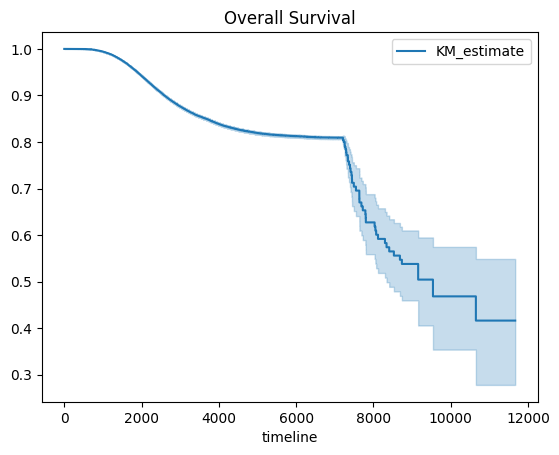

In [17]:
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(durations = df_train["SurvivalDays"], event_observed = df_train["Default"])
kmf.plot_survival_function()
plt.title("Overall Survival")

Text(0.5, 1.0, 'Survival of different Naics Big Category group')

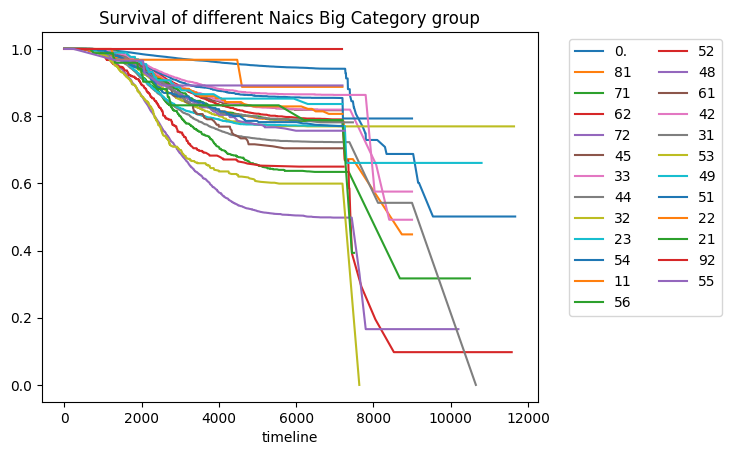

In [18]:
import matplotlib.pyplot as plt

naics_big_cat = df_train["NaicsCode"].apply(lambda x: str(x)[:2])
cat_list = list(naics_big_cat.unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (naics_big_cat == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.title("Survival of different Naics Big Category group")

Text(0.5, 1.0, 'Survival of different Borrower State group')

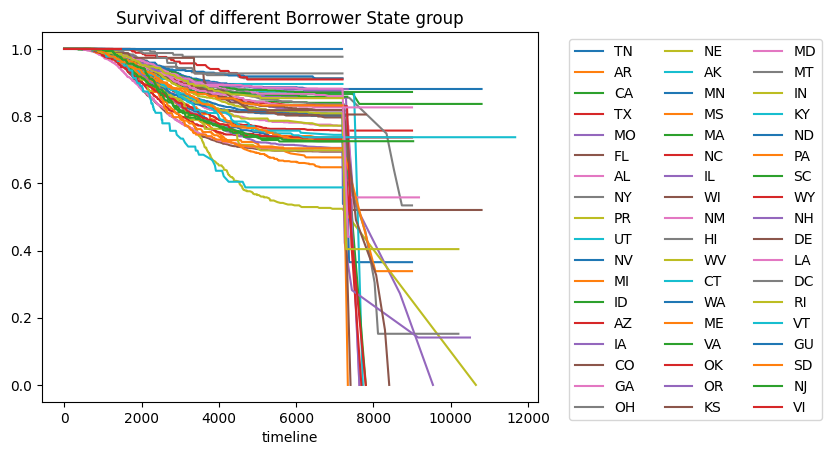

In [19]:
cat_list = list(df_train["BorrState"].unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (df_train["BorrState"] == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.title("Survival of different Borrower State group")

Text(0.5, 1.0, 'Survival of different Project State group')

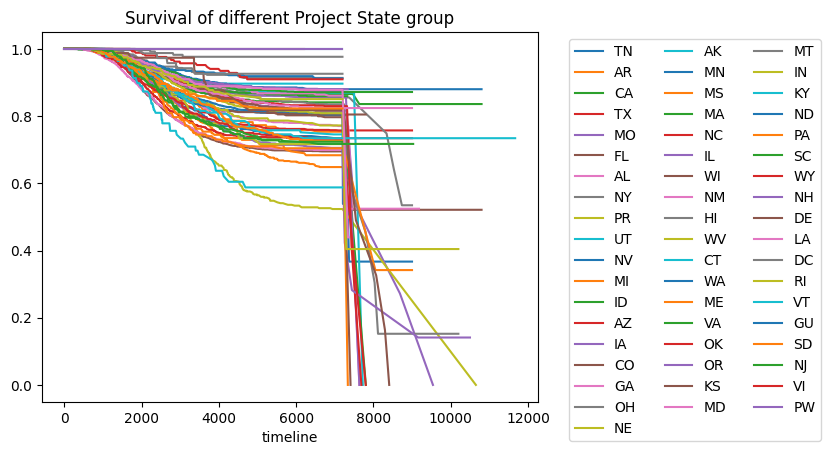

In [20]:
cat_list = list(df_train["ProjectState"][~df_train["ProjectState"].isna()].unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (df_train["ProjectState"] == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.title("Survival of different Project State group")

## 6  Hazard Model without Time Variables

In [21]:
df_train["20JobsSupported"] = df_train["JobsSupported"] >= 20

use_cols = ["GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState","Default","SurvivalDays"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw = df_train[use_cols]
for cat in cat_cols:
    dummies = pd.get_dummies(df_train[cat], prefix = cat)
    df_raw = pd.concat([df_raw, dummies], axis = 1)
    df_raw = df_raw.drop(cat, axis = 1)

In [22]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_raw, duration_col = 'SurvivalDays', event_col = 'Default')
cph.print_summary()

C:\Users\caixu\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['DeliveryMethod_Direct Loans', 'BorrState_VI'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 101703 total observations, 90213 right-censored observations>
             duration col = 'SurvivalDays'
                event col = 'Default'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 101703
number of events observed = 11490
   partial log-likelihood = -122413.58
         time fit was run = 2025-02-14 18:44:42 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
GrossApproval                                                    0.00      1.00      0.00            0.00            0.00                1.00                1.00
TermInMonths                                                    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
20JobsSupported                                                 -0.18      0.83      0.02           -0.21           -0.15                0.81                0.86
DeliveryMethod_504                                              -0.23      0.79      0.02           -0.26           -0.20                0.77                0.82
DeliveryMethod_ALP                                               0.20      1.23      0.02            0.17            0.24                1.19                1.27
DeliveryMethod_Direct Loans                                     -0.81      0.44      1.36           -3.47            1.84                0.03                6.31
DeliveryMethod_PCLP                                              0.13      1.14      0.03            0.07            0.19                1.08                1.21
Subprogram_Sec. 504 - Delta loans, funded 9/26/95               -0.52      0.60      0.37           -1.25            0.22                0.29                1.24
Subprogram_Sec. 504 - Loan Guarantees - Private Sector Financed -0.07      0.93      0.03           -0.13           -0.02                0.88                0.98
Subprogram_Sec. 504 - Premier Certified Lender Program           0.08      1.08      0.03            0.02            0.13                1.02                1.14
NaicsCodeBigCategory_0.                                         -0.57      0.57      0.02           -0.60           -0.53                0.55                0.59
NaicsCodeBigCategory_11                                         -0.03      0.97      0.09           -0.21            0.15                0.81                1.17
NaicsCodeBigCategory_21                                          0.08      1.08      0.23           -0.38            0.54                0.69                1.71
NaicsCodeBigCategory_22                                         -0.32      0.73      0.36           -1.03            0.40                0.36                1.49
NaicsCodeBigCategory_23                                          0.17      1.19      0.03            0.11            0.23                1.12                1.26
NaicsCodeBigCategory_31                                          0.03      1.03      0.06           -0.08            0.14                0.92                1.15
NaicsCodeBigCategory_32                                          0.06      1.06      0.04           -0.02            0.13                0.98                1.14
NaicsCodeBigCategory_33                                         -0.06      0.94      0.03           -0.12           -0.00                0.89                1.00
NaicsCodeBigCategory_42                                         -0.21      0.81      0.03           -0.26           -0.15                0.77                0.86
NaicsCodeBigCategory_44                                          0.23      1.25      0.02            0.18            0.27                1.20             

In [23]:
df_test["NaicsCodeBigCategory"] = df_test["NaicsCode"].apply(lambda x: str(x)[:2])
df_test["20JobsSupported"] = df_test["JobsSupported"] >= 20

df_raw_test = df_test[use_cols]
for cat in cat_cols:
    values_raw = list(df_train[cat][~df_train[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)

survival = cph.predict_survival_function(df_raw_test, times=((df_raw_test["TermInMonths"]*30).astype(int).unique())).transpose()
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["TermInMonths"]*30)], axis=1)

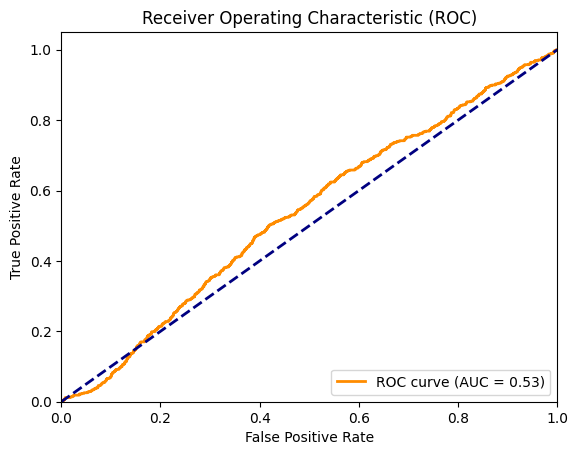

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test = pd_predict["Default"]
y_prob = pd_predict["PredictedDefaultProb"]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 7  Hazard Model with GDP Growth Rate of ApprovedFiscalYear

In [25]:
gdp = pd.read_csv("US_GDP_Growth_Rate_1980_2023.csv")
gdp.loc[len(gdp)] = [2024, 0]  # 2024 GDP growth rate not available yet, use 0

In [26]:
df_train_gdp = pd.merge(df_train, gdp, left_on='ApprovalFiscalYear', right_on='Year')
df_test_gdp = pd.merge(df_test, gdp, left_on='ApprovalFiscalYear', right_on='Year')

In [27]:
df_train_gdp["20JobsSupported"] = df_train_gdp["JobsSupported"] >= 20

use_cols = ["GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState","Default","SurvivalDays"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw = df_train_gdp[use_cols]
for cat in cat_cols:
    dummies = pd.get_dummies(df_train_gdp[cat], prefix = cat)
    df_raw = pd.concat([df_raw, dummies], axis = 1)
    df_raw = df_raw.drop(cat, axis = 1)

In [28]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_raw, duration_col = 'SurvivalDays', event_col = 'Default')
cph.print_summary()

C:\Users\caixu\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['DeliveryMethod_Direct Loans', 'BorrState_VI'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 101703 total observations, 90213 right-censored observations>
             duration col = 'SurvivalDays'
                event col = 'Default'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 101703
number of events observed = 11490
   partial log-likelihood = -121888.32
         time fit was run = 2025-02-14 18:44:48 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
GDPGrowthRate                                                   -0.14      0.87      0.00           -0.15           -0.14                0.86                0.87
GrossApproval                                                    0.00      1.00      0.00            0.00            0.00                1.00                1.00
TermInMonths                                                    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
20JobsSupported                                                 -0.18      0.84      0.02           -0.21           -0.15                0.81                0.86
DeliveryMethod_504                                              -0.22      0.80      0.02           -0.25           -0.19                0.78                0.83
DeliveryMethod_ALP                                               0.20      1.22      0.02            0.16            0.23                1.18                1.26
DeliveryMethod_Direct Loans                                     -0.82      0.44      1.35           -3.47            1.84                0.03                6.27
DeliveryMethod_PCLP                                              0.11      1.12      0.03            0.05            0.17                1.05                1.18
Subprogram_Sec. 504 - Delta loans, funded 9/26/95               -0.46      0.63      0.38           -1.20            0.29                0.30                1.33
Subprogram_Sec. 504 - Loan Guarantees - Private Sector Financed -0.07      0.93      0.03           -0.13           -0.01                0.88                0.99
Subprogram_Sec. 504 - Premier Certified Lender Program           0.07      1.07      0.03            0.02            0.13                1.02                1.14
NaicsCodeBigCategory_0.                                         -0.52      0.60      0.02           -0.56           -0.48                0.57                0.62
NaicsCodeBigCategory_11                                         -0.03      0.97      0.09           -0.21            0.15                0.81                1.16
NaicsCodeBigCategory_21                                          0.08      1.08      0.23           -0.38            0.53                0.69                1.71
NaicsCodeBigCategory_22                                         -0.31      0.73      0.37           -1.03            0.41                0.36                1.50
NaicsCodeBigCategory_23                                          0.17      1.19      0.03            0.11            0.23                1.12                1.26
NaicsCodeBigCategory_31                                          0.02      1.02      0.06           -0.09            0.13                0.92                1.14
NaicsCodeBigCategory_32                                          0.05      1.05      0.04           -0.02            0.12                0.98                1.13
NaicsCodeBigCategory_33                                         -0.06      0.94      0.03           -0.12           -0.01                0.89                0.99
NaicsCodeBigCategory_42                                         -0.20      0.82      0.03           -0.26           -0.15                0.77             

In [29]:
df_test_gdp["NaicsCodeBigCategory"] = df_test_gdp["NaicsCode"].apply(lambda x: str(x)[:2])
df_test_gdp["20JobsSupported"] = df_test_gdp["JobsSupported"] >= 20

df_raw_test = df_test_gdp[use_cols]
for cat in cat_cols:
    values_raw = list(df_train_gdp[cat][~df_train_gdp[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)

survival = cph.predict_survival_function(df_raw_test, times=((df_raw_test["TermInMonths"]*30).astype(int).unique())).transpose()
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["TermInMonths"]*30)], axis=1)

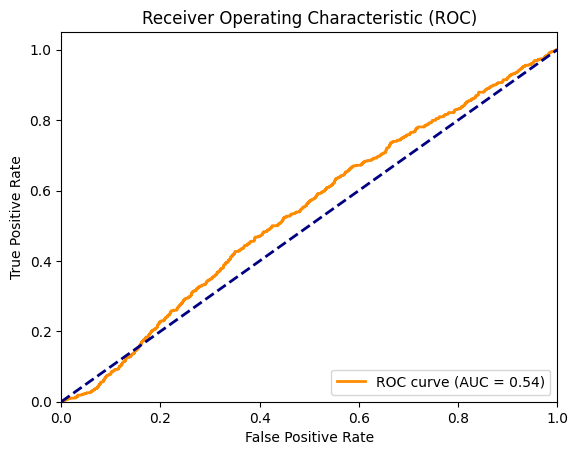

In [30]:
y_test = pd_predict["Default"]
y_prob = pd_predict["PredictedDefaultProb"]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [32]:
df_train["BorrState"].unique()

array(['TN', 'AR', 'CA', 'TX', 'MO', 'FL', 'AL', 'NY', 'PR', 'UT', 'NV',
       'MI', 'ID', 'AZ', 'IA', 'CO', 'GA', 'OH', 'NE', 'AK', 'MN', 'MS',
       'MA', 'NC', 'IL', 'WI', 'NM', 'HI', 'WV', 'CT', 'WA', 'ME', 'VA',
       'OK', 'OR', 'KS', 'MD', 'MT', 'IN', 'KY', 'ND', 'PA', 'SC', 'WY',
       'NH', 'DE', 'LA', 'DC', 'RI', 'VT', 'GU', 'SD', 'NJ', 'VI'],
      dtype=object)

In [33]:
df_train

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,CDC_Zip,ThirdPartyLender_Name,ThirdPartyLender_City,ThirdPartyLender_State,ThirdPartyDollars,GrossApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,Subprogram,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,BusinessAge,LoanStatus,PaidInFullDate,ChargeOffDate,GrossChargeOffAmount,JobsSupported,Default,SurvivalDays,LossAtDefault,NaicsCodeBigCategory,JS20,20JobsSupported
4766,2024-09-30,504,COLONY RESORT HOTEL,1109 PARKWAY,GATLINBURG,TN,37738,Areawide Development Corporati,523 West Lamar Alexander Parkw,Maryville,TN,37801.0,NaN,NaN,NaN,NaN,847000.0,1993-06-29,1993,8/11/1993,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,0.0,NaN,NaN,NaN,SEVIER,TN,TENNESSEE DISTRICT OFFICE,1.0,PARTNERSHIP,NaN,EXEMPT,NaT,NaT,0,32,False,6395,0,0.,True,True
8746,2024-09-30,504,"R & R AUTO BATH & LUBE, INC.",1900 N REYNOLDS RD POB 624,BYRANT,AR,72089,Six Bridges Capital Corporatio,200 River Market Avenue,Little Rock,AR,72201.0,NaN,NaN,NaN,NaN,249000.0,1994-08-08,1994,5/17/1995,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,811192.0,Car Washes,NaN,NaN,SALINE,AR,ARKANSAS DISTRICT OFFICE,2.0,CORPORATION,NaN,EXEMPT,NaT,NaT,0,17,False,5990,0,81,False,False
9974,2024-09-30,504,MANDO'S STEREO,244 MAIN STREET,EL CENTRO,CA,92243,CDC Small Business Finance Cor,2448 Historic Decatur Road,San Diego,CA,92106.0,NaN,NaN,NaN,NaN,135000.0,1995-08-09,1995,2/14/1996,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,0.0,NaN,NaN,NaN,SAN DIEGO,CA,SAN DIEGO DISTRICT OFFICE,51.0,INDIVIDUAL,NaN,EXEMPT,NaT,NaT,0,9,False,5624,0,0.,False,False
12124,2024-09-30,504,WHITEWOOD LANES,3632 50TH STREET,LUBBOCK,TX,79413,Caprock Business Finance Corpo,1323 58th Street,Lubbock,TX,79452.0,NaN,NaN,NaN,NaN,375000.0,1995-05-17,1995,8/16/1995,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,713950.0,Bowling Centers,NaN,NaN,LUBBOCK,TX,LUBBOCK DISTRICT OFFICE,19.0,CORPORATION,NaN,EXEMPT,NaT,NaT,0,27,False,5708,0,71,True,True
12412,2024-09-30,504,KRUMBLY BURGER,635 STURGEON,MONTGOMERY CITY,MO,63370,Enterprise Development Corpora,910 East Broadway,Columbia,MO,65201.0,NaN,NaN,NaN,NaN,50000.0,1995-09-19,1995,1/15/1997,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,0.0,NaN,NaN,NaN,MONTGOMERY,MO,ST. LOUIS DISTRICT OFFICE,0.0,INDIVIDUAL,NaN,EXEMPT,NaT,NaT,0,8,False,5583,0,0.,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13949,2024-09-30,504,Dairy Queen,3064 Coon Rapids Blvd NW.,Coon rapids (rr name coon cree,MN,55433,Minnesota Business Finance Cor,616 Roosevelt Road,St. Cloud,MN,56301.0,KENSINGTON BANK,Kensington,MN,250000.0,181000.0,2010-12-15,2011,5/11/2011,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,722211.0,Limited-Service Restaurants,21780,DAIRY QUEEN,ANOKA,MN,MINNESOTA DISTRICT OFFICE,3.0,CORPORATION,NaN,CHGOFF,NaT,2017-05-13,151390,3,True,2341,151390,72,False,False
14401,2024-09-30,504,Days Inn & Suites,110 N. Outer Road.,St. james,MO,65559,Meramec Regional Development C,4 Industrial Drive,St. James,MO,65559.0,HERITAGE COMMUNITY BANK,Chamois,MO,1016500.0,618000.0,2010-11-17,2011,4/13/2011,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,721110.0,Hotels (except Casino Hotels) and Motels,22470,DAYS INN,PHELPS,MO,ST. LOUIS DISTRICT OFFICE,3.0,CORPORATION,NaN,CHGOFF,NaT,2013-06-22,604504,15,True,948,604504,72,False,False
14662,2024-09-30,504,Gosch's Inc.,517 Pacific Ave.,Randall,MN,56475,Minnesota Business Finance Cor,616 Roosevelt Road,St. Cloud,MN,56301.0,RANDALL STATE BANK,Randall,MN,425000.0,347000.0,2010-11-18,2011,3/16/2011,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,445110.0,Supermarkets and Other Grocery (except Conveni...,NaN,NaN,MORR